In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mygrad import sliding_window_view

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, LSTM
import tensorflow as tf

%matplotlib notebook

Functions from POMS_sentiment used to load existing dictionary

In [3]:
def load_sent_dict(path="sent_dict.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_sent_dict(sent_dict, path="sent_dict.txt"):
    with open(path, "wb") as f:
        pickle.dump(sent_dict, f, pickle.HIGHEST_PROTOCOL)

def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [4]:
sent_dict = load_sent_dict(path="sent_dict.txt")

Functions from DJIA_preprocess used to load DJIA data

In [5]:
def load_djia(path="djia_ts.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_djia(ts, path="djia_ts.txt"):
    with open(path, "wb") as f:
        pickle.dump(ts, f, pickle.HIGHEST_PROTOCOL)

In [6]:
djia = load_djia(path="djia_ts.txt")

Load in relevant part of the DJIA data for training, zscore it, and create time series for Calm and Happy

In [7]:
train_djia = djia[130:130+98]
#train_djia = djia[:98]
train_djia = (train_djia - np.mean(train_djia)) / np.std(train_djia)

In [8]:
calm = -sentiment_time_series(sent_dict, "tension") - sentiment_time_series(sent_dict, "anger")
happy = sentiment_time_series(sent_dict, "vigour") - sentiment_time_series(sent_dict, "depression")
alert = -sentiment_time_series(sent_dict, "fatigue") - sentiment_time_series(sent_dict, "confusion")

dfft = np.fft.fft(calm)
dfft[30:] = 0
calm = np.real(np.fft.ifft(dfft))

dfft = np.fft.fft(happy)
dfft[30:] = 0
happy = np.real(np.fft.ifft(dfft))

dfft = np.fft.fft(alert)
dfft[30:] = 0
alert = np.real(np.fft.ifft(dfft))

This function creates a dataset by looking at "windows" of previous time series values. In other words, we're trying to predict a stock value on each day by looking at sentiment data in the past $N$ days. Obviously this means we can't do predictions for the first $N$ days which makes sense.

Experiment: to augment time series data with previous returns, you could attempt to pass DJIA data to this function as well as other time series.

We can then easily generate our training data using a call of this function.

In [9]:
def windowed_data(window_size, *ts_data):
    k = window_size * len(ts_data)
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, k))
    
    for i, ts in enumerate(ts_data):
        dataset[:,window_size*i:window_size*(i+1)] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset[:-1]

In [10]:
N = 3
x_train = windowed_data(N+1, calm, happy, alert)
y_train = train_djia[N:-1]
x_train.shape, y_train.shape

((94, 12), (94,))

This function will test any of our prediction algorithms by a simple cross validation.

In [11]:
def cross_validate_model(k, x_data, y_data, model):
    size = int(len(x_data) / k)
    
    prediction = np.zeros(y_data.shape)
        
    for i in range(k):
        
        if i == k-1:
            x_train = x_data[:i*size]
            y_train = y_data[:i*size]

            x_test = x_data[i*size:]
            y_test = y_data[i*size:]
            
            prediction[i*size:] = model(x_test, x_train, y_train)
        else:
            x_train = np.concatenate((x_data[:i*size], x_data[(i+1)*size:]))
            y_train = np.concatenate((y_data[:i*size], y_data[(i+1)*size:]))

            x_test = x_data[i*size:(i+1)*size]
            y_test = y_data[i*size:(i+1)*size]
        
            prediction[i*size:(i+1)*size] = model(x_test, x_train, y_train)
            
        print("Fold " + str(i) + " trained.")
        
    return prediction

def mape(truth, prediction):
    #return np.abs(truth - prediction)
    return np.mean(np.abs((truth - prediction) / truth))

def rmse(truth, prediction):
    return np.sqrt(np.mean((truth - prediction) ** 2))

def accuracy(truth, prediction, lag):
    length = len(truth)
    correct = 0.0
    for i in range(lag,length):
        lastTruth = np.mean(truth[i-lag:i])
        lastPred  = np.mean(prediction[i-lag:i])
        if (truth[i] >= lastTruth and prediction[i] >= lastPred):
            correct += 1
        elif (truth[i] <= lastTruth and prediction[i] <= lastPred):
            correct += 1
    
    return correct / (length - lag)

Our first (very simple) prediction algorithm: linear regression

In [12]:
def linreg_prediction(A, x_train, y_train):
    factor = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
    return np.matmul(A, factor)

<IPython.core.display.Javascript object>


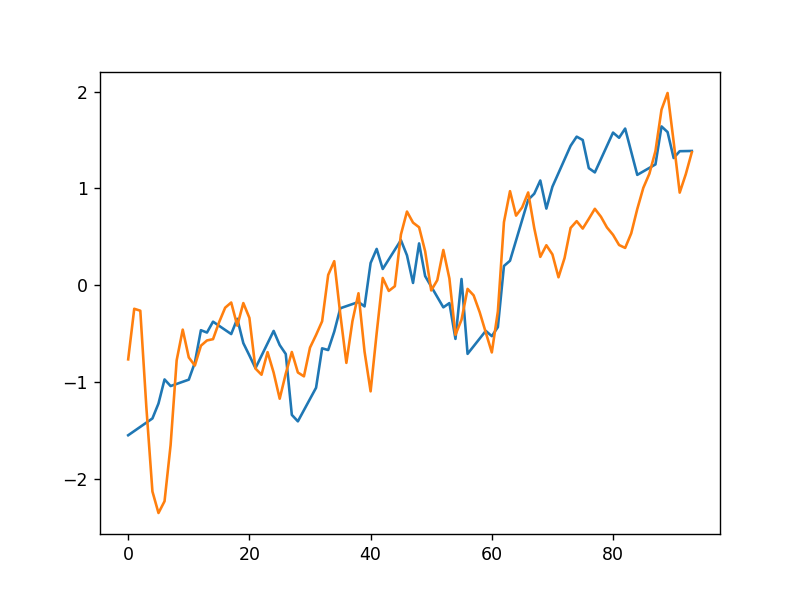

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


In [13]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(cross_validate_model(5, x_train, y_train, linreg_prediction))

In [14]:
linear_output = cross_validate_model(5, x_train, y_train, linreg_prediction)
rmse(y_train, linear_output), accuracy(y_train, linear_output, 1)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


(0.5700713159311542, 0.4731182795698925)

Model for a dense neural network with 3 sigmoid layers.

In [15]:
model = Sequential()
model.add(Dense(128, input_shape=((1+N)*3,), activation="sigmoid"))
model.add(Dense(32, activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [16]:
history = model.fit(x_train, y_train, epochs=300, batch_size=20, verbose=0, validation_split=0.2)

<IPython.core.display.Javascript object>


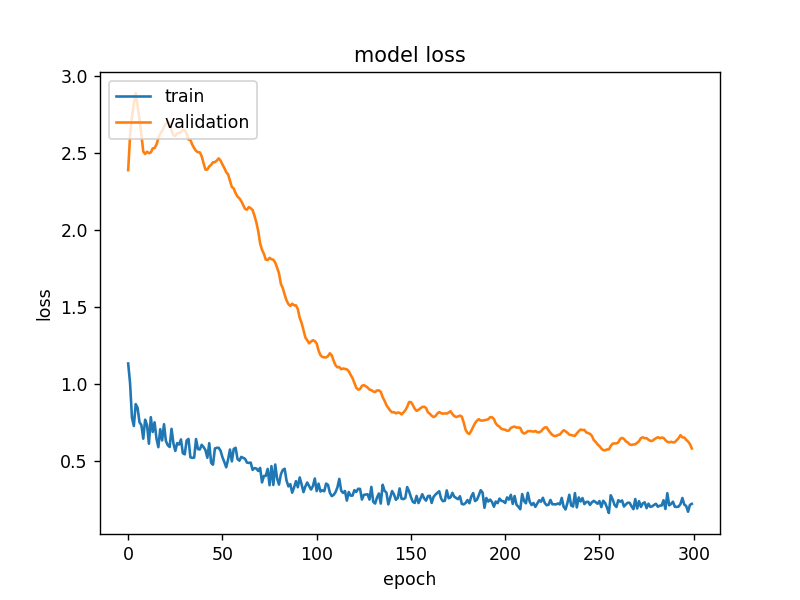

In [17]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
def dense_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(Dense(512, input_shape=(3*(N+1),), activation="sigmoid"))
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='adagrad', metrics=['mse', 'mae'])
    model.fit(x_train, y_train, epochs=300, batch_size=10, verbose=0)
    
    return model.predict(A).flatten()

In [130]:
dense_output = cross_validate_model(5, x_train, y_train, dense_prediction)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


<IPython.core.display.Javascript object>


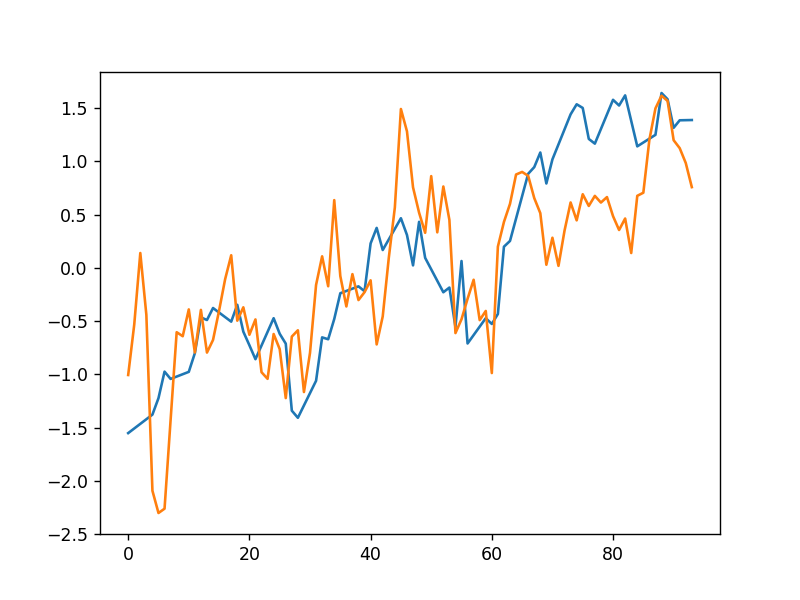

In [131]:
fig, ax = plt.subplots()
ax.plot(y_train)

ax.plot(dense_output)
#ax.plot(np.random.rand(94))

In [133]:
rmse(y_train, dense_output), accuracy(y_train, dense_output, 1)

(0.6329879118824862, 0.5483870967741935)

Finally, we'll use a *recurrent* neural network for our last type of model. In particular we'll use a long-short term memory network or LSTM with 256 filters. This requires a slightly different windowed data function, but trains in much the same way as the dense network.

In [28]:
def windowed_data_lstm(window_size, *ts_data):
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, window_size, len(ts_data)))
    
    for i, ts in enumerate(ts_data):
        dataset[:,:,i] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset

In [29]:
x_train_lstm = windowed_data_lstm(7, calm, happy, alert)
y_train_lstm = train_djia[6:]

In [30]:
model = Sequential()
model.add(LSTM(256, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

In [31]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=500, batch_size=5, verbose=1, validation_split=0.2)

Train on 73 samples, validate on 19 samples
Epoch 1/1
73/73 [==============================] - 3s 41ms/step - loss: 0.3661 - mean_squared_error: 0.3661 - mean_absolute_error: 0.4725 - val_loss: 1.1237 - val_mean_squared_error: 1.1237 - val_mean_absolute_error: 1.0276


The training for an LSTM is more volatile than for the dense network on this small dataset, as shown below.

<IPython.core.display.Javascript object>


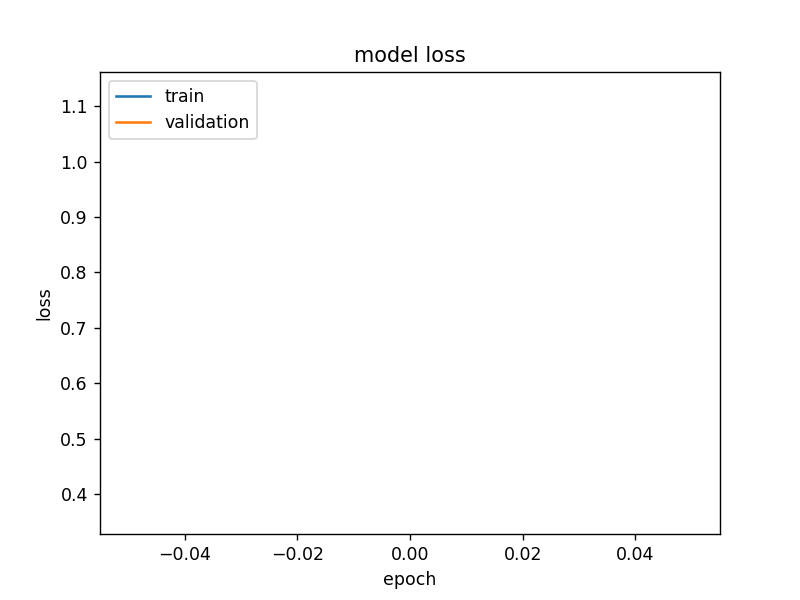

In [32]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [213]:
def lstm_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(LSTM(512, activation="relu", return_sequences=True))
    model.add(LSTM(512, activation="relu"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

    model.fit(x_train, y_train, epochs=300, batch_size=10, verbose=0)
    
    return model.predict(A).flatten()

In [214]:
lstm_output = cross_validate_model(5, x_train_lstm, y_train_lstm, lstm_prediction)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


The LSTM obtains a better accuracy score compared to the dense network and linear regression despite comparable mean error. Thus, the LSTM is most likely the best model to use.

<IPython.core.display.Javascript object>


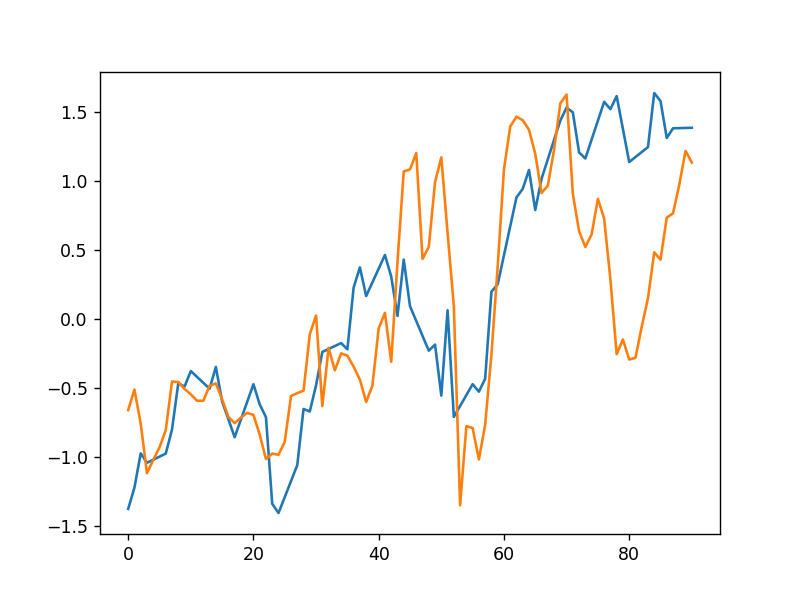

In [215]:
fig, ax = plt.subplots()
ax.plot(y_train_lstm[1:])

ax.plot(lstm_output[1:])

In [223]:
rmse(y_train_lstm, lstm_output), accuracy(y_train_lstm, lstm_output, 1)

(0.6598331751557786, 0.6923076923076923)

Now that we have all 3 models, we can plot all of the results against each other.

<IPython.core.display.Javascript object>


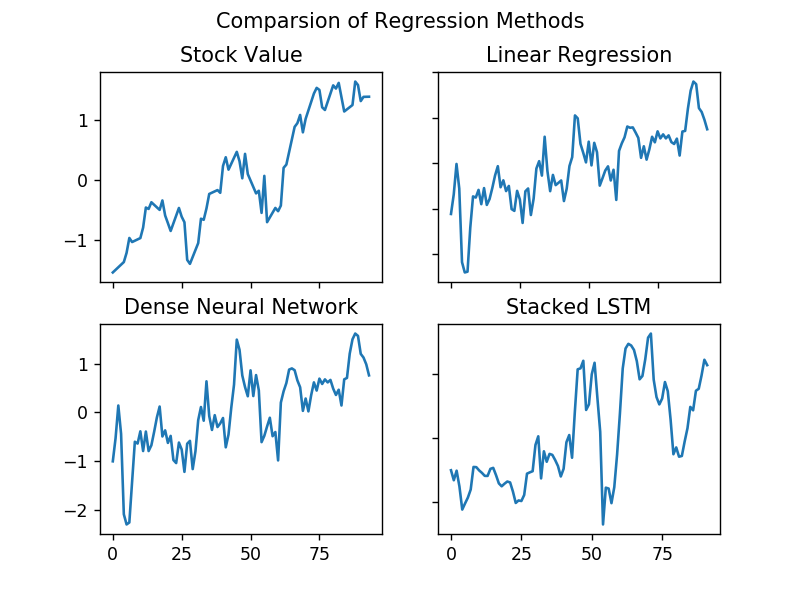

In [239]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.suptitle("Comparsion of Regression Methods")

ax[0][0].set_title("Stock Value")
ax[0][0].plot(y_train)

ax[0][1].set_title("Linear Regression")
ax[0][1].plot(linear_output)

ax[1][0].set_title("Dense Neural Network")
ax[1][0].plot(dense_output)

ax[1][1].set_title("Stacked LSTM")
ax[1][1].plot(lstm_output)

for ax in ax.flat:
    ax.label_outer()